# Testing our formulation of the stress intensity factor against examples from the literature

We've selected two areas from two studies to test the stress intensity factor computation using the derived local stress fields. For each "crack", we

1. Sample the points along the crack from the stress grids to construct the stress tensors
1. Get a depth-averaged stress tensor for each point
2. Rotate the stress tensors into a ridge-normal/ridge-parallel coordinate system
3. Extract the ridge-normal stresses that "load" the crack
4. Integrate the crack loading along the ridge to compute the stress intensity factor

$$
K_I = \frac{2}{H}\left(\frac{a}{\pi}\right)^{1/2}\int_a \frac{p\left(x\right)}{\left(a^2 - x^2 \right)^{1/2}}\, dx
$$

In [1]:
import numpy as np
import math
import os
import pygmt
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline
from ridgetools import *

pygmt-session [ERROR]: Unable to open GMT shared mbsystem library: dlopen(/usr/local/lib/mbsystem.so, 1): Library not loaded: /usr/local/opt/gdal/lib/libgdal.28.dylib
  Referenced from: /usr/local/lib/mbsystem.so
  Reason: image not found


## Loading a ridge segment and getting all stress components

The stress grids are on the cryosat drive, so it is best to run the following commands on that machine. I put a clone of this environment and a python script in my directory there. The routine outputs a csv data table which can (and should) be saved for loading later.

In [4]:
filename = os.getcwd() + "/segments/Galapagos-west.txt"
galaRidge = load_one_ridge(filename)

In [6]:
gridDir = '/cryosat/huharper/01_topo-stress/stress_img/'
depths = [-0.5,-1.5,-2.5,-3.5,-4.5,-5.5,-6.5]
stresses = ['Txx','Tyy','Tzz','Txy','Txz','Tyz']

for depth in depths:
    for stress in stresses:
        gridFileName = gridDir + stress + '_' + str(depth) + '.nc'

        galaRidge = sample_ridge_on_grid(galaRidge,gridFileName)
        
galaRidge.to_csv('galapagos-west.all')

## Get the loading stress for a crack
All the data is stored in the galapagos-west pandas dataframe. The following block will get the loading stress at each sampled point.

In [2]:
galaRidge = pd.read_csv('segments/Galapagos-west.csv',index_col=0)

n = galaRidge.shape[0]
ridgeAzi = get_ridge_azimuth(galaRidge)
ridgeLoading = np.zeros((n,))

for ii in range(0,n):
    onePoint = galaRidge.iloc[ii,:]
    ridgeLoading[ii] = get_loading_stress(onePoint,ridgeAzi)
x = lonlat2x(galaRidge)
ridgeLoading = ridgeLoading*10e6

In [3]:
K = compute_K(x,ridgeLoading)
print('K = {:e} Pa m^(1/2)'.format(K))

K = -2.433576e+09 Pa m^(1/2)


## An alternative loading function
The two papers mentioned earlier use an alternative loading function based only on the depth relative to the surrounding seafloor.

In [6]:
rho_l = 2900 # density of lithosphere
rho_w = 1035 # density of water
g = 9.8 #
H = 7e3 # plate thickness, m

deps = pygmt.grdtrack(galaRidge.iloc[:,0:2],'/Users/huharper/Research/99_grids/SRTM15+V2.nc',newcolname='depth')
deps = deps.iloc[:,-1]
delDep = deps + 2600 # this is an ad hoc depth for the Galapagos ridge
altRidgeLoading = (rho_l - rho_w)*g*delDep*H/2
KAlt = compute_K(x,altRidgeLoading)
print('K = {:e} Pa m^(1/2)'.format(KAlt))

K = 1.870002e+09 Pa m^(1/2)


## Notes
So, as it stands, the calculation for the galapagos ridge is about two orders of magnitude less than the value given in PM & P. Why might that be?

1. Slight mismatch b/t my digitized ridge and the referenced. Their ridge extends slightly farther both east and west. However, this shouldn't make much of a difference.
2. Improper depth-averaging of the stress field
3. Improper integration scheme or limits of integration
4. others?

## Solution
1. p(x) is a force per unit length, not a stress. So, this should be integrated along depth instead of averaged.
2. Elastic thickness in the topo_stress routine was set to 7km, instead of the proper 0km, so some amount of the stress is due to flexure

## Plot depth profile, crack loading profiles

In [7]:
deps = pygmt.grdtrack(galaRidge.iloc[:,0:2],'/Users/huharper/Research/99_grids/SRTM15+V2.nc',newcolname='depth')

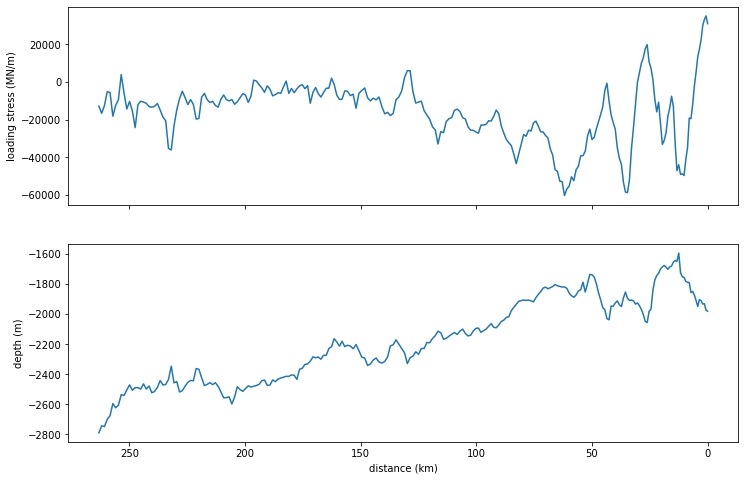

In [26]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=(12,8))
ax[0].plot(x*1e-3,ridgeLoading*1e-6)
ax[0].set_ylabel('loading stress (MN/m)')
ax[1].plot(x*1e-3,deps.iloc[:,-1])
ax[1].set_ylabel('depth (m)')
ax[1].set_xlabel('distance (km)')
ax[0].invert_xaxis()

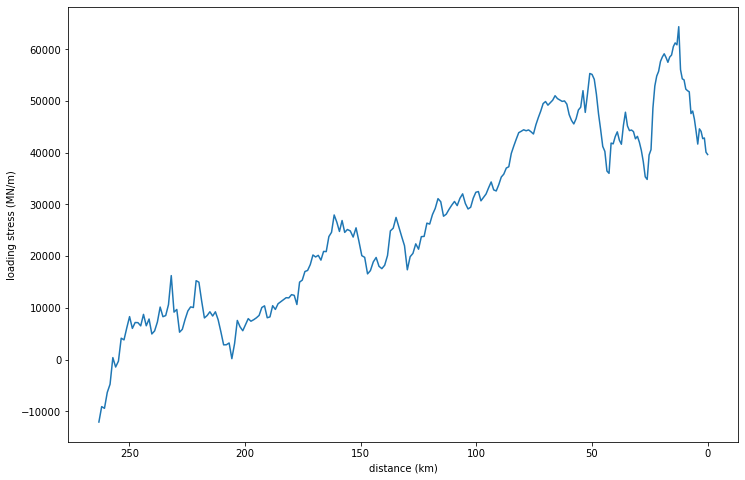

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x*1e-3,altRidgeLoading*1e-6)
ax.set_ylabel('loading stress (MN/m)')
ax.set_xlabel('distance (km)')
ax.invert_xaxis()

This is essentially the result from PM & P, except they completely linearized the topography, so there's no short wavelength variations, just a line trending down. Our result for K is on the same order of magnitude. These loading stresses are kind of enormous.

## Stress variations w/ depth


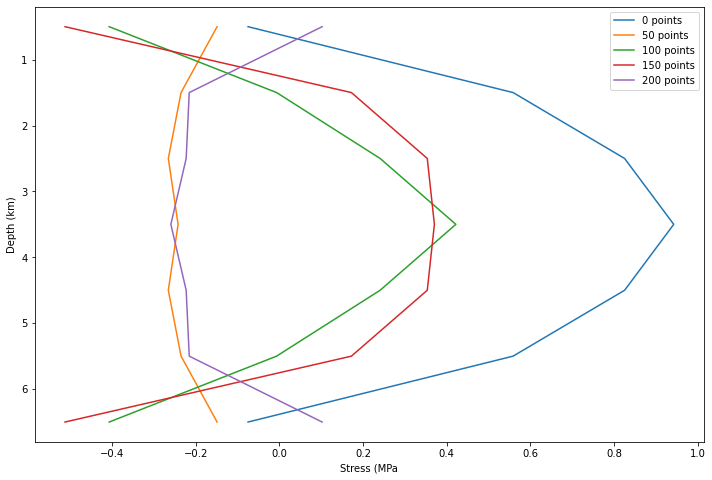

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
yy_stress = np.zeros((7,))
for jj in (0,50,100,150,200):
    for ii in range(0,7):
        yy_stress[ii] = galaRidge.iloc[jj,ii*6 + 3]
    lblStr = '{} points'.format(jj)
    ax.plot(yy_stress,np.arange(0,7) + 0.5,label=lblStr)
ax.invert_yaxis()
ax.set_xlabel('Stress (MPa')
ax.set_ylabel('Depth (km)')
ax.legend()

In [7]:
ridge = pd.read_csv('segments/Natl-PR.csv',index_col=0)

n = ridge.shape[0]
ridgeAzi = get_ridge_azimuth(ridge)
ridgeLoading = np.zeros((n,))

for ii in range(0,n):
    onePoint = ridge.iloc[ii,:]
    ridgeLoading[ii] = get_loading_stress(onePoint,ridgeAzi)
x = lonlat2x(ridge)
ridgeLoading = ridgeLoading*10e6

K = compute_K(x,ridgeLoading)
print('K = {:e} Pa m^(1/2)'.format(K))

K = 6.907449e+09 Pa m^(1/2)


In [8]:
ridge = pd.read_csv('segments/Natl-FR.csv',index_col=0)

n = ridge.shape[0]
ridgeAzi = get_ridge_azimuth(ridge)
ridgeLoading = np.zeros((n,))

for ii in range(0,n):
    onePoint = ridge.iloc[ii,:]
    ridgeLoading[ii] = get_loading_stress(onePoint,ridgeAzi)
x = lonlat2x(ridge)
ridgeLoading = ridgeLoading*10e6

K = compute_K(x,ridgeLoading)
print('K = {:e} Pa m^(1/2)'.format(K))

K = -4.704985e+09 Pa m^(1/2)


### Needed:
Some sanity checks. For instance, print out the ridge azimuth, length, etc...
A driver function so I can just give a file/ridge name and not copy/paste over n over